In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import sklearn

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []
scores = []

for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    for para in [x.find('span', itemprop = "ratingValue") for x in parsed_content.find_all("div", {"class": "rating-10"})]:
        if len(para.get_text()) <= 2:
            scores.append(int(para.get_text()))
    
    
    print(f"   ---> {len(reviews)} total reviews")
    print(len(scores))

Scraping page 1
   ---> 100 total reviews
100
Scraping page 2
   ---> 200 total reviews
200
Scraping page 3
   ---> 300 total reviews
300
Scraping page 4
   ---> 400 total reviews
400
Scraping page 5
   ---> 500 total reviews
500
Scraping page 6
   ---> 600 total reviews
600
Scraping page 7
   ---> 700 total reviews
700
Scraping page 8
   ---> 800 total reviews
800
Scraping page 9
   ---> 900 total reviews
900
Scraping page 10
   ---> 1000 total reviews
1000


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df["scores"] = scores
df.head()

,reviews,scores
0,✅ Trip Verified | Excellent service both on th...,9
1,✅ Trip Verified | Good lounge at Cape Town. O...,9
2,✅ Trip Verified | A really excellent journey....,9
3,✅ Trip Verified | This flight was one of the ...,2
4,Not Verified | It seems that there is a race t...,3


In [4]:
df.to_csv("BA_reviews.csv")

In [5]:
print(df)

                                               reviews  scores
0    ✅ Trip Verified | Excellent service both on th...       9
1    ✅ Trip Verified |  Good lounge at Cape Town. O...       9
2    ✅ Trip Verified |  A really excellent journey....       9
3    ✅ Trip Verified |  This flight was one of the ...       2
4    Not Verified | It seems that there is a race t...       3
..                                                 ...     ...
995  ✅ Trip Verified | Flew British Airways from Lo...       1
996  ✅ Trip Verified |  Madrid to London. The main ...       3
997  ✅ Trip Verified |  London to Moscow. British A...       1
998  ✅ Trip Verified |  Miami to London. My most re...       9
999  ✅ Trip Verified |  Gatwick to Barbados in Dece...       4

[1000 rows x 2 columns]


In [6]:
df['reviews'] = df.reviews.str.split('|').str[1]

In [7]:
df['reviews'] = df.reviews.str.strip()
print(df)

                                               reviews  scores
0    Excellent service both on the ground and on bo...       9
1    Good lounge at Cape Town. On time departure. D...       9
2    A really excellent journey. Lounge not overcro...       9
3    This flight was one of the worst I have ever h...       2
4    It seems that there is a race to the bottom am...       3
..                                                 ...     ...
995  Flew British Airways from London Heathrow to D...       1
996  Madrid to London. The main plus about this fli...       3
997  London to Moscow. British Airways has downgrad...       1
998  Miami to London. My most recent BA experience ...       9
999  Gatwick to Barbados in December 2017. On a 9 h...       4

[1000 rows x 2 columns]


In [ ]:
#NLP

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

#analysis_text = df['reviews'].to_string(index=False)

#wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = STOPWORDS, min_font_size = 10).generate(analysis_text)
# plot the WordCloud image                      
#plt.figure(figsize = (8, 8), facecolor = None)
#plt.imshow(wordcloud)
#plt.axis("off")
#plt.tight_layout(pad = 0)
#plt.show()

In [9]:
#classifing reviews as positive or negative or neutral
#scores of 1-3 are classified as negative, 4-6 are neutral (won't train/test the model on these reviews but will leave them in the dataframe for the sake of completeness and to classify them later) and 7-10 are positive

df['sentiment'] = df['scores'].apply(lambda rating : +1 if rating > 6 else (-1 if rating < 4 else 0))
df.head()


,reviews,scores,sentiment
0,Excellent service both on the ground and on bo...,9,1
1,Good lounge at Cape Town. On time departure. D...,9,1
2,A really excellent journey. Lounge not overcro...,9,1
3,This flight was one of the worst I have ever h...,2,-1
4,It seems that there is a race to the bottom am...,3,-1


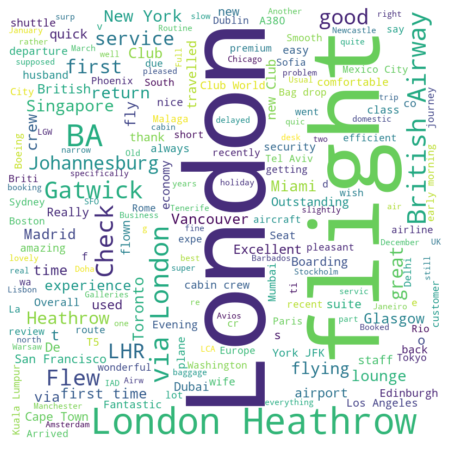

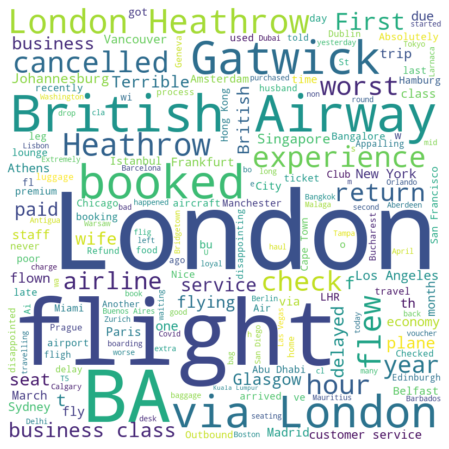

In [10]:
#splitting the reviews into a positive and negitive dataframe to check most common words in each category

positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == -1]

#positive.head()
#negative.head()
posText = positive['reviews'].to_string(index=False)
pos_wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = STOPWORDS, min_font_size = 10).generate(posText)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

negText = negative['reviews'].to_string(index=False)
neg_wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = STOPWORDS, min_font_size = 10).generate(negText)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#These are not particularly useful because there are so many useless/repeated words in both.
#next I will create lists of the most common words from the positive and negative reviews and then eliminate the ones that appear in both list and then do this again
#this is purely for the generation of wordclouds, for now at least. I think this might be something that I can apply to my model later to make it more accurate later. But
#I will try it without removing words first. 


In [11]:
#generating lists of words and their rate of occurance (using the bag of words model)
from sklearn.feature_extraction.text import CountVectorizer
vectorizerPos = CountVectorizer()
vectorizerNeg = CountVectorizer()
pos_BOW = vectorizerPos.fit_transform(positive['reviews'])
neg_BOW = vectorizerNeg.fit_transform(negative['reviews'])

positive_words = vectorizerPos.get_feature_names()
negative_words = vectorizerNeg.get_feature_names()

#trying sentiment analysis without removing words:
#first create new dataframe with just reviews and sentiments, as well as removing neutral reviews as they are not useful for training/testing the model

new_df = df[['reviews','sentiment']]
new_df = new_df[new_df['sentiment']!=0]
new_df.head()

,reviews,sentiment
0,Excellent service both on the ground and on bo...,1
1,Good lounge at Cape Town. On time departure. D...,1
2,A really excellent journey. Lounge not overcro...,1
3,This flight was one of the worst I have ever h...,-1
4,It seems that there is a race to the bottom am...,-1


In [12]:
#first clean the reviews more - remove punctuation, special characters, numbers etc. + stopwords and apply stemming.

def keep_only_letters(text):
    text = re.sub(r'[^a-zA-Z\s]','',text)
    return text
def convert_to_lowercase(text):
    return text.lower()
def clean_reviews(text):
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text

english_stopwords = nltk.corpus.stopwords.words('english')

def remove_stop_words(text):
    for stopword in english_stopwords:
        stopword = ' ' + stopword + ' '
        text = text.replace(stopword, ' ')
    return text

def text_stemming(text):
    stemmer = nltk.porter.PorterStemmer()
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])
    return stemmed

new_df['reviews'] = new_df['reviews'].agg([clean_reviews, remove_stop_words, text_stemming])

#new_df.head()
new_df.shape[0]

843

In [13]:
#using 80% of the data to train and the remaining 20% to test --> so 673 rows to train, 169 to test. note: the code would break if more reviews are added but for testing purposes this code is acceptable

training = new_df[:673]
testing = new_df[673:]
training_labels = [1 if sentiment==1 else 0 for sentiment in training['sentiment']]
testing_labels = [1 if sentiment==1 else 0 for sentiment in testing['sentiment']]
#print (len(train_labels), len(test_labels))

vectorizer = CountVectorizer(binary=False,ngram_range=(1,1))
tf_features_train = vectorizer.fit_transform(training['reviews'])
tf_features_test = vectorizer.transform(testing['reviews'])
#print(tf_features_train.shape, tf_features_test.shape)

#using logistic regression:
clfLG = sklearn.linear_model.LogisticRegression(solver='lbfgs')
clfLG.fit(tf_features_train, training_labels)
#print(clf)

predictions = clfLG.predict(tf_features_test)
print(sklearn.metrics.classification_report(testing_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(testing_labels, predictions, labels=[0, 1]))


              precision    recall  f1-score   support

    Negative       0.89      0.93      0.91       101
    Positive       0.89      0.83      0.86        69

    accuracy                           0.89       170
   macro avg       0.89      0.88      0.88       170
weighted avg       0.89      0.89      0.89       170

[[94  7]
 [12 57]]


Logistic Regression:
In the above code, using unigrams gives and accuracy of: 88% 
using unigrams + bigrams gives an accuracy of: 85% 
and using unigrams, bigrams and trigrams gives an accuracy of: 85%
(I just manually changed the ngram_range and re-ran the code instead of copy pasting it 3 times)


In [15]:
#using support vector machine for comparison

vectorizer = CountVectorizer(binary=False,ngram_range=(1,1))
tf_features_train = vectorizer.fit_transform(training['reviews'])
tf_features_test = vectorizer.transform(testing['reviews'])
#print(tf_features_train.shape, tf_features_test.shape)

clfSVM = sklearn.svm.LinearSVC()
clfSVM.fit(tf_features_train, training_labels)

predictions = clfSVM.predict(tf_features_test)
print(sklearn.metrics.classification_report(testing_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(testing_labels, predictions, labels=[0, 1]))

              precision    recall  f1-score   support

    Negative       0.90      0.93      0.92       101
    Positive       0.89      0.85      0.87        65

    accuracy                           0.90       166
   macro avg       0.90      0.89      0.89       166
weighted avg       0.90      0.90      0.90       166

[[94  7]
 [10 55]]


Linear SVM:

results - unigram: 89%
        - unigram and bigram: 87%
        - unigram, bigram and trigram: 86%

In [16]:
#using Naive Bayes:

from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer(binary=False,ngram_range=(1,1))
tf_features_train = vectorizer.fit_transform(training['reviews'])
tf_features_test = vectorizer.transform(testing['reviews'])
#print(tf_features_train.shape, tf_features_test.shape)

clfNB = MultinomialNB()
clfNB.fit(tf_features_train, training_labels)

predictions = clfNB.predict(tf_features_test)
print(sklearn.metrics.classification_report(testing_labels, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(testing_labels, predictions, labels=[0, 1]))

              precision    recall  f1-score   support

    Negative       0.95      0.90      0.92       101
    Positive       0.86      0.92      0.89        65

    accuracy                           0.91       166
   macro avg       0.90      0.91      0.91       166
weighted avg       0.91      0.91      0.91       166

[[91 10]
 [ 5 60]]


Naive Bayes:

results - unigram: 91%
        - unigram and bigram: 89%
        - unigram, bigram and trigram: 85%

something interesting to note here is that Naive Bayes is much better as predicting negative reviews vs positive reviews (96% vs 86%) for unigrams (it evens out for when we add bigrams and trigrams). The other models don't have this large of a difference.


In summary: the best model for this data is the Naive Bayes model using unigrams only.

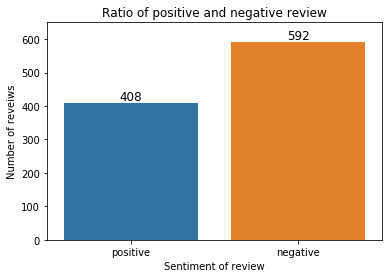

In [17]:
#saving the model:

import pickle

saved_model = pickle.dumps(clfNB)
NBmodel_from_pickle = pickle.loads(saved_model)


#using the model on the dataset:

#first cleaning the original data
df['reviews'] = df['reviews'].agg([clean_reviews, remove_stop_words, text_stemming])


#vectorizing the reviews and then putting them through the model
all_reviews = vectorizer.transform(df['reviews'])
results = np.ndarray.tolist(NBmodel_from_pickle.predict(all_reviews)) #results array contain 0's for negative predictions and 1's for positive prediction

indexCount = 0
for value in results:
    if value == 1:
        results[indexCount] = "positive"
        indexCount += 1
    elif value == 0:
        results[indexCount] = "negative"
        indexCount += 1
    else:
        print("error")
        break

positiveReviewCounter = 0
negativeReviewCounter = 0

for item in results:
    if item == "positive":
        positiveReviewCounter += 1
    elif item == "negative":
        negativeReviewCounter += 1
    else:
        print("error")
        break

#print(positiveReviewCounter)
#print(negativeReviewCounter)

#plotting ratio of positive to negative reviews
import seaborn as sns

ax = sns.barplot(x=["positive", "negative"], y=[positiveReviewCounter, negativeReviewCounter])
ax.set(xlabel='Sentiment of review', ylabel='Number of reveiws', title='Ratio of positive and negative review')
ax.set_ylim([0,650])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

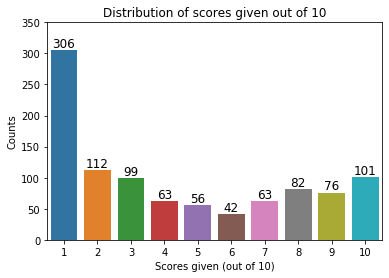

In [18]:
#finding the distribution of scores

ax = sns.countplot(x='scores',data=df)
ax.set(xlabel='Scores given (out of 10)', ylabel='Counts', title='Distribution of scores given out of 10')
ax.set_ylim([0,350])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')

In [19]:
#finding statistics of the data

mean = np.mean(df['scores'])
median = np.median(df['scores'])
std = np.std(df['scores'])
print('The mean score of all reviews is: ', mean)
print('The median score of all the reviews is:  ', median)
print('The standard deviation of the scores is: ', std)

#adding the results of the sentiment analysis to the dataframe
df['sentiment_from_model'] = results


#finding the average score of positive and negative reviews
positive_sentiment_scores = []
negative_sentiment_scores = []

select_pos = df.loc[df['sentiment_from_model'] == 'positive']
sel_pos_index = select_pos.index
select_neg = df.loc[df['sentiment_from_model'] == 'negative']
sel_neg_index = select_neg.index

for index in sel_pos_index:
    positive_sentiment_scores.append(df['scores'][index])
for index in sel_neg_index:
    negative_sentiment_scores.append(df['scores'][index])


#print(positive_sentiment_scores)
#print(negative_sentiment_scores)

mean_pos_reviews = np.round(np.mean(positive_sentiment_scores), 2)
mean_neg_reviews = np.round(np.mean(negative_sentiment_scores), 2)

print('The mean score of positive reviews is: ', mean_pos_reviews)
print('The mean score of negative reviews is: ', mean_neg_reviews)

The mean score of all reviews is:  4.402
The median score of all the reviews is:   3.0
The standard deviation of the scores is:  3.2830467556829035
The mean score of positive reviews is:  7.72
The mean score of negative reviews is:  2.12


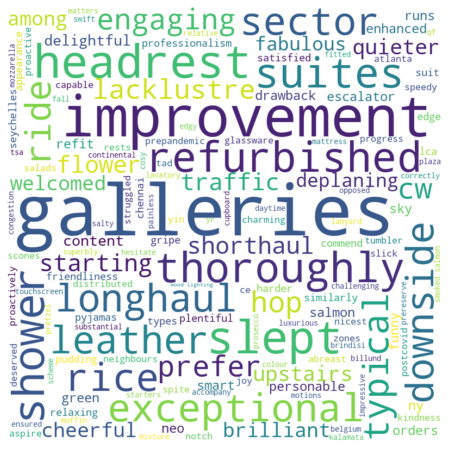

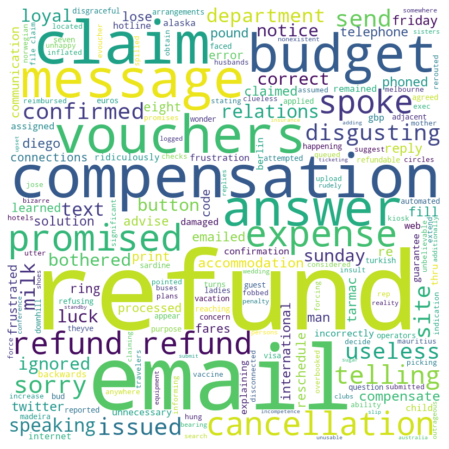

In [39]:
#trying to find the most common words in positive/negative reviews (also to regenerate wordclouds)

tokenizer = WhitespaceTokenizer()

pos_df = df.loc[df['sentiment_from_model'] == 'positive']
pos_list = pos_df['reviews'].tolist()
neg_df = df.loc[df['sentiment_from_model'] == 'negative']
neg_list = neg_df['reviews'].tolist()

pos_list_to_string = ' '.join([str(elem) for elem in pos_list])  
neg_list_to_string = ' '.join([str(elem) for elem in neg_list])
filtered_pos_list = [w for w in tokenizer.tokenize(pos_list_to_string)] 
filtered_neg_list = [w for w in tokenizer.tokenize(neg_list_to_string)]
fd_pos = nltk.FreqDist(filtered_pos_list) 
fd_neg = nltk.FreqDist(filtered_neg_list)

#combined_list_pos = [item for sublist in zip(filtered_pos_list, fd_pos.values()) for item in sublist]

filtered_pos, filtered_neg = [i for i in filtered_pos_list if i not in filtered_neg_list], [j for j in filtered_neg_list if j not in filtered_pos_list]

pos_words_string = ' '.join(filtered_pos) #the inputs need to be strings of text hence converting the lists of words to long strings containing all the words
neg_words_string = ' '.join(filtered_neg)

positve_reviews_wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = STOPWORDS, min_font_size = 10).generate(pos_words_string)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(positve_reviews_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

negative_reviews_wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = STOPWORDS, min_font_size = 10).generate(neg_words_string)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(negative_reviews_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



